# GPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset, ConcatDataset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
"""
for i in df['interval'].unique():
    id = df['interval'] == i
    plt.plot(df[id]['time_within_interval'].to_numpy(), df[id]['B.RTD1'].to_numpy())
plt.xlabel('time (min)')
plt.ylabel('Temperature (°C)')
plt.show()
"""
df_c = df[df['temp_change_class'] == 'c']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)

class RICO4Dataset(Dataset):
    def __init__(self, df_c):
        self.df_c = df_c
        self.unique_intervals = df_c['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df_c['interval'] == batch
        temp = torch.tensor(self.df_c[id]['B.RTD1'].to_numpy(), dtype=torch.float32)
        ti = torch.tensor(self.df_c[id]['time_within_interval'].to_numpy()/240, dtype=torch.float32)
        x_batch = torch.cat((temp.unsqueeze(1), ti.unsqueeze(1)), axis=1)
        return x_batch
dataset = RICO4Dataset(df_c)

# Split the dataset into above_20 and below_20
above_20_data = []
below_20_data = []

for idx in range(len(dataset)):
    x_batch = dataset[idx]
    starting_value = x_batch[0, 0].item()  # Get the starting value of B.RTD1
    if starting_value > 20:
        above_20_data.append(x_batch)
    else:
        below_20_data.append(x_batch)

# Define custom datasets for above_20 and below_20
class SubsetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create DataLoader instances
below_20_dataset = SubsetDataset(below_20_data)
above_20_dataset = SubsetDataset(above_20_data)

train_loader = DataLoader(above_20_dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed
val_loader = DataLoader(below_20_dataset, batch_size=1, shuffle=True)

# Check DataLoader sizes
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Number of batches in train_loader: 21
Number of batches in val_loader: 7


/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_23377/3360712211.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
# Initialize the VAE
torch.manual_seed(1)
model = GPVAE(GP_inf = GP_inference(kernel), 
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])

In [4]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [5]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Progress:   5%|▍         | 49/1000 [00:04<01:23, 11.45it/s]

Epoch 50:
  Training - Loss = 10.7690, KL = 0.4212, MSE = 10.7732, CE = 1.2640
  Validation - Loss = 13.2786, KL = 0.4242, MSE = 13.2829, CE = 1.1955
  Mean q_mu = 0.6593, Mean q_var = 0.6680


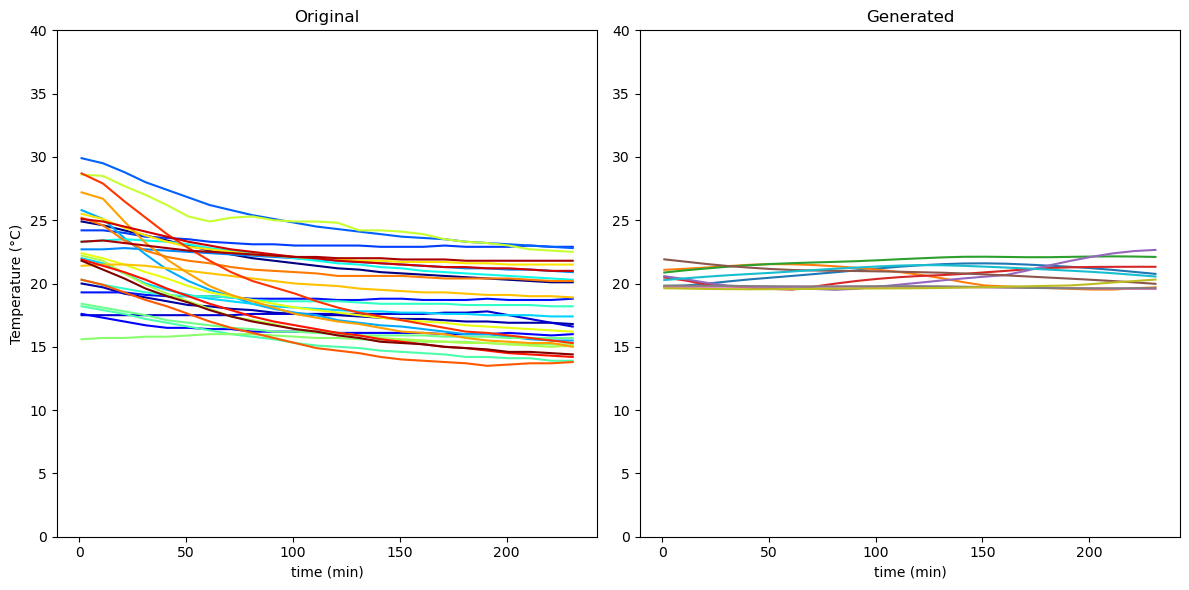

Training Progress:  10%|▉         | 99/1000 [00:09<01:19, 11.38it/s]

Epoch 100:
  Training - Loss = 6.0950, KL = 0.2612, MSE = 6.0976, CE = 0.5238
  Validation - Loss = 6.4711, KL = 0.3288, MSE = 6.4744, CE = 0.4904
  Mean q_mu = 1.4012, Mean q_var = 0.1420


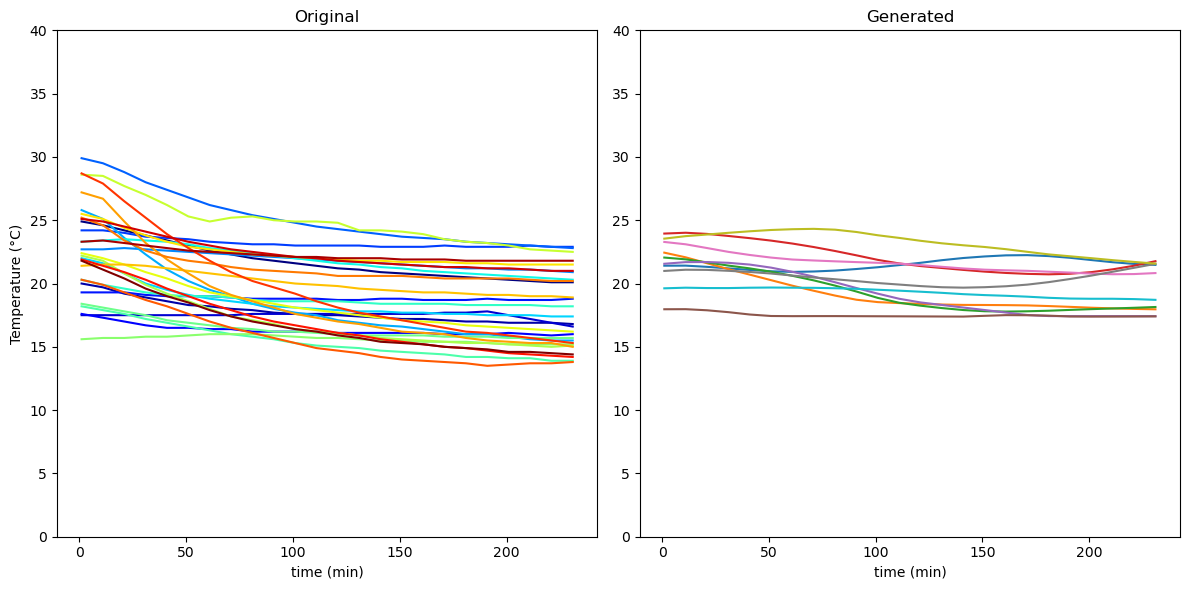

Training Progress:  15%|█▍        | 149/1000 [00:13<01:16, 11.18it/s]

Epoch 150:
  Training - Loss = 1.1781, KL = 0.1140, MSE = 1.1793, CE = 0.0328
  Validation - Loss = 0.8281, KL = 0.2724, MSE = 0.8308, CE = 0.0186
  Mean q_mu = 1.4210, Mean q_var = 0.0503


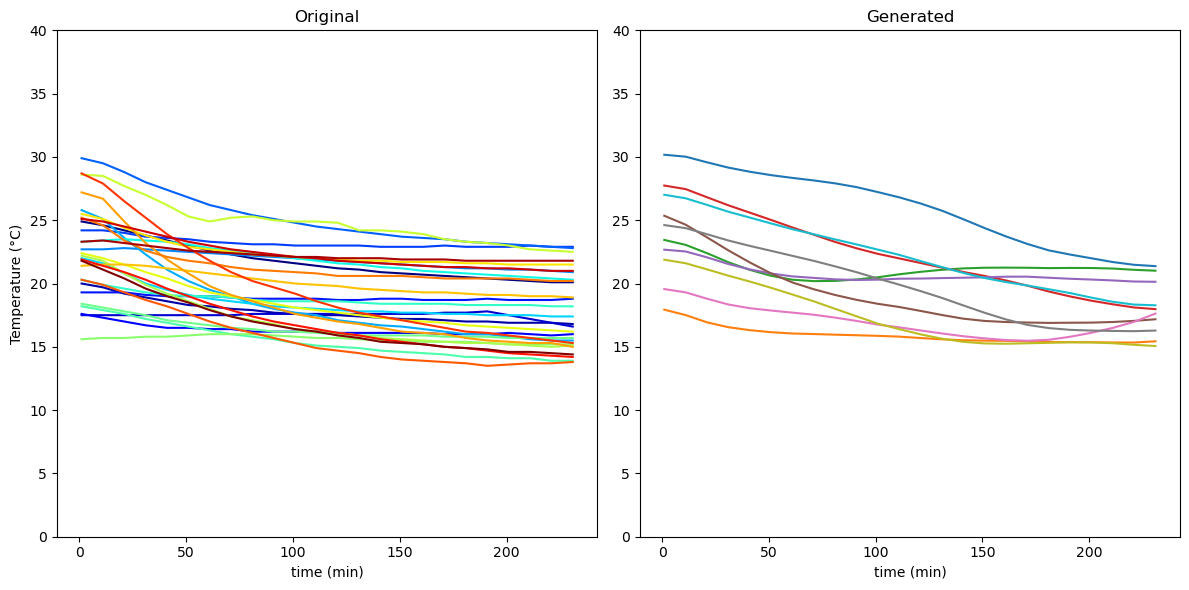

Training Progress:  20%|█▉        | 198/1000 [00:18<01:10, 11.43it/s]

Epoch 200:
  Training - Loss = 0.7468, KL = 0.0406, MSE = 0.7472, CE = 0.0397
  Validation - Loss = 0.5289, KL = 0.2554, MSE = 0.5314, CE = 0.0130
  Mean q_mu = 1.6517, Mean q_var = 0.0500


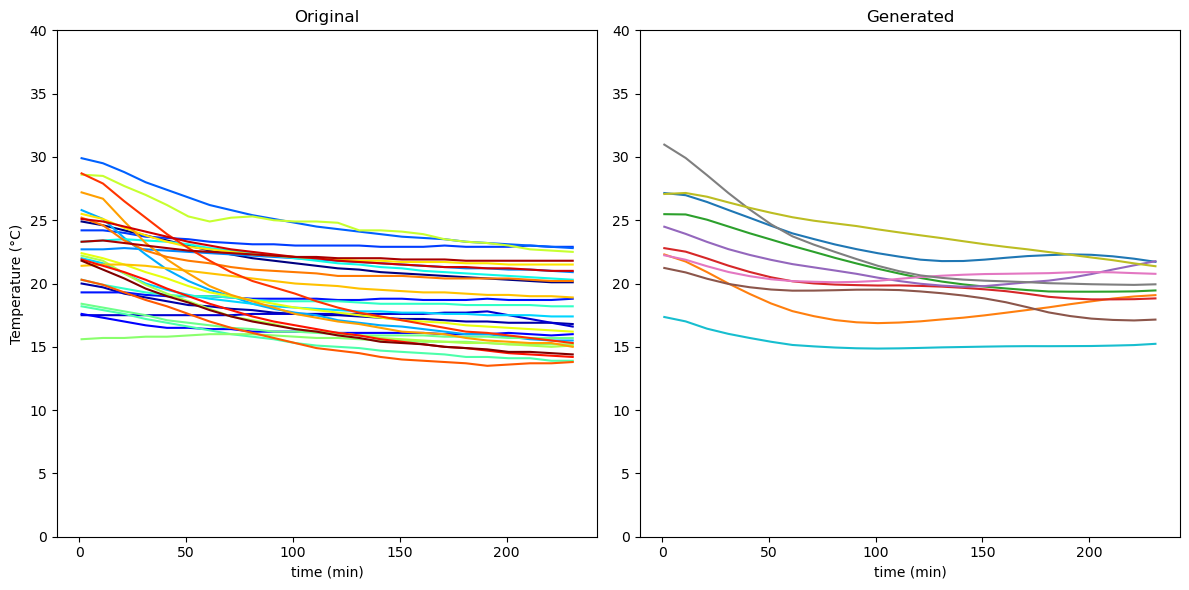

Training Progress:  25%|██▍       | 248/1000 [00:22<01:05, 11.48it/s]

Epoch 250:
  Training - Loss = 0.6933, KL = -0.0406, MSE = 0.6929, CE = 0.0504
  Validation - Loss = 0.3444, KL = 0.2460, MSE = 0.3469, CE = 0.0155
  Mean q_mu = 1.8767, Mean q_var = 0.0499


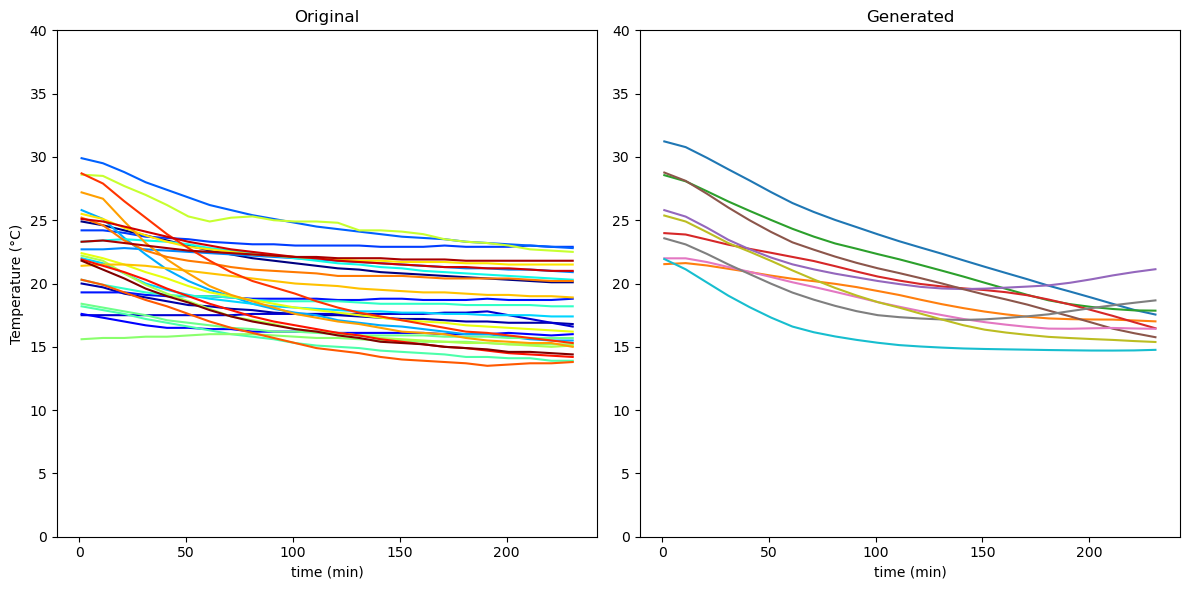

Training Progress:  30%|██▉       | 299/1000 [00:27<01:02, 11.13it/s]

Epoch 300:
  Training - Loss = 0.4023, KL = -0.1143, MSE = 0.4012, CE = 0.0621
  Validation - Loss = 0.2933, KL = 0.2322, MSE = 0.2957, CE = 0.0205
  Mean q_mu = 2.0088, Mean q_var = 0.0499


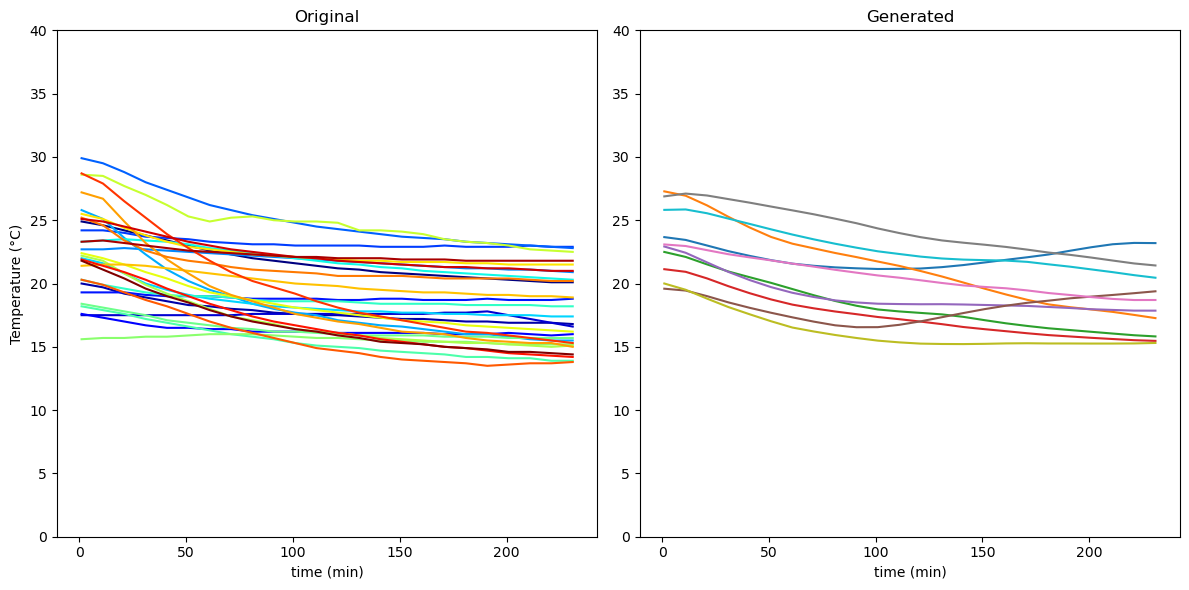

Training Progress:  35%|███▍      | 349/1000 [00:32<00:57, 11.40it/s]

Epoch 350:
  Training - Loss = 0.4545, KL = -0.1791, MSE = 0.4527, CE = 0.0745
  Validation - Loss = 0.2136, KL = 0.2291, MSE = 0.2159, CE = 0.0245
  Mean q_mu = 2.0507, Mean q_var = 0.0499


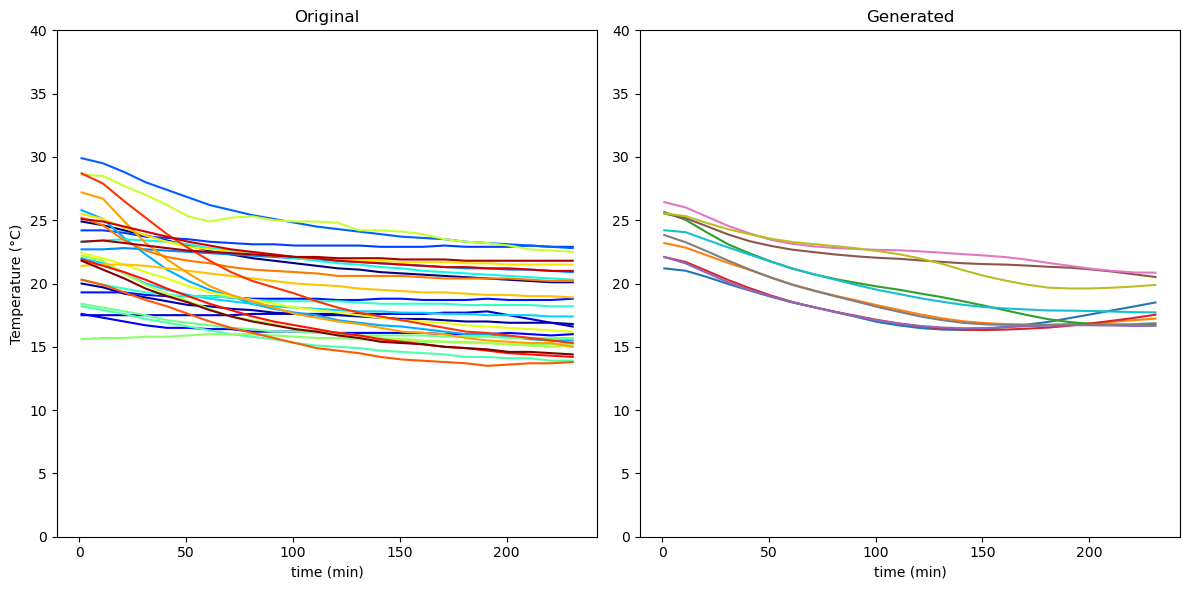

Training Progress:  40%|███▉      | 399/1000 [00:36<00:52, 11.39it/s]

Epoch 400:
  Training - Loss = 0.3128, KL = -0.2502, MSE = 0.3103, CE = 0.0860
  Validation - Loss = 0.2267, KL = 0.2195, MSE = 0.2289, CE = 0.0290
  Mean q_mu = 2.1021, Mean q_var = 0.0498


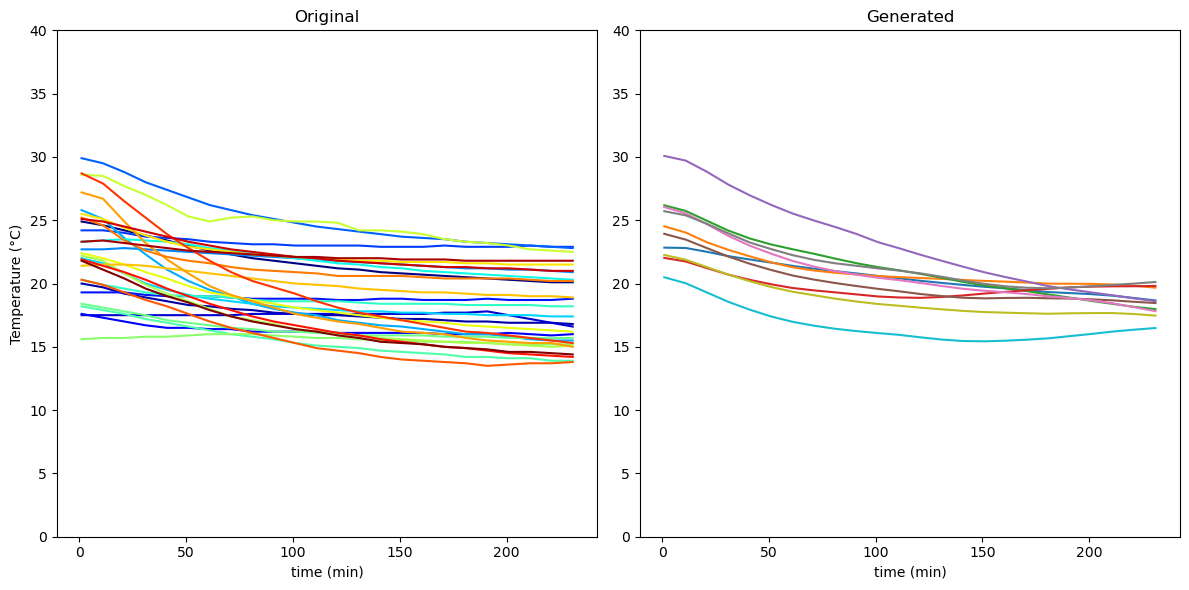

Training Progress:  45%|████▍     | 449/1000 [00:41<00:48, 11.45it/s]

Epoch 450:
  Training - Loss = 0.3123, KL = -0.3357, MSE = 0.3090, CE = 0.0969
  Validation - Loss = 0.2816, KL = 0.2102, MSE = 0.2837, CE = 0.0335
  Mean q_mu = 2.2151, Mean q_var = 0.0498


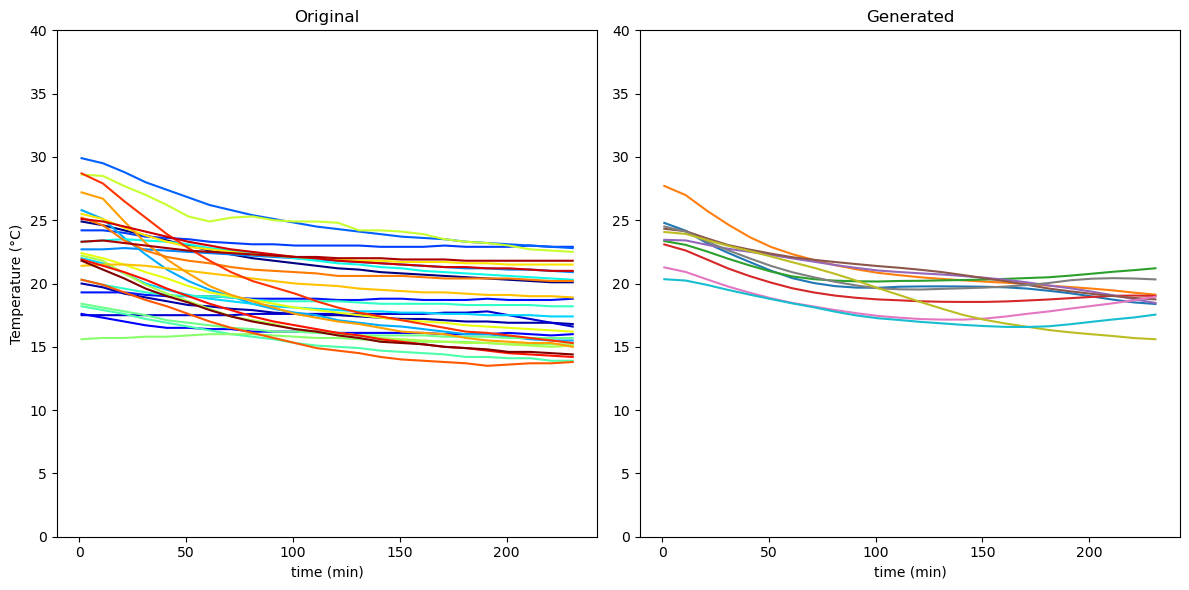

Training Progress:  50%|████▉     | 499/1000 [00:45<00:43, 11.46it/s]

Epoch 500:
  Training - Loss = 0.2345, KL = -0.4292, MSE = 0.2302, CE = 0.1047
  Validation - Loss = 0.1521, KL = 0.1867, MSE = 0.1540, CE = 0.0393
  Mean q_mu = 2.4427, Mean q_var = 0.0498


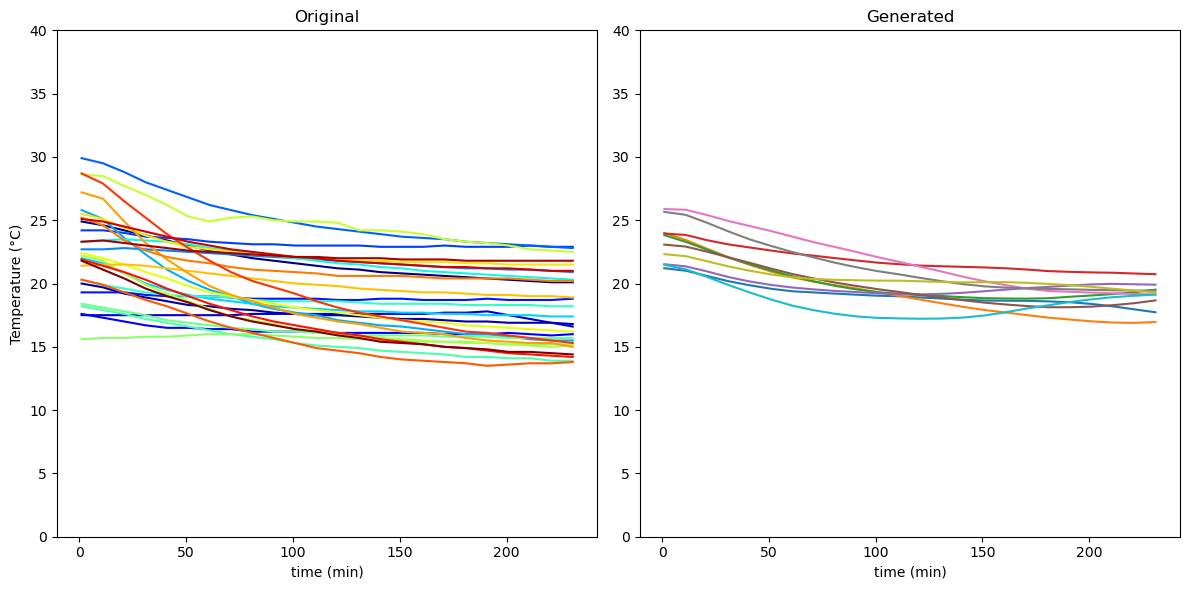

Training Progress:  55%|█████▍    | 549/1000 [00:50<00:40, 11.26it/s]

Epoch 550:
  Training - Loss = 0.2022, KL = -0.5118, MSE = 0.1971, CE = 0.1111
  Validation - Loss = 0.1310, KL = 0.1701, MSE = 0.1327, CE = 0.0440
  Mean q_mu = 2.6155, Mean q_var = 0.0498


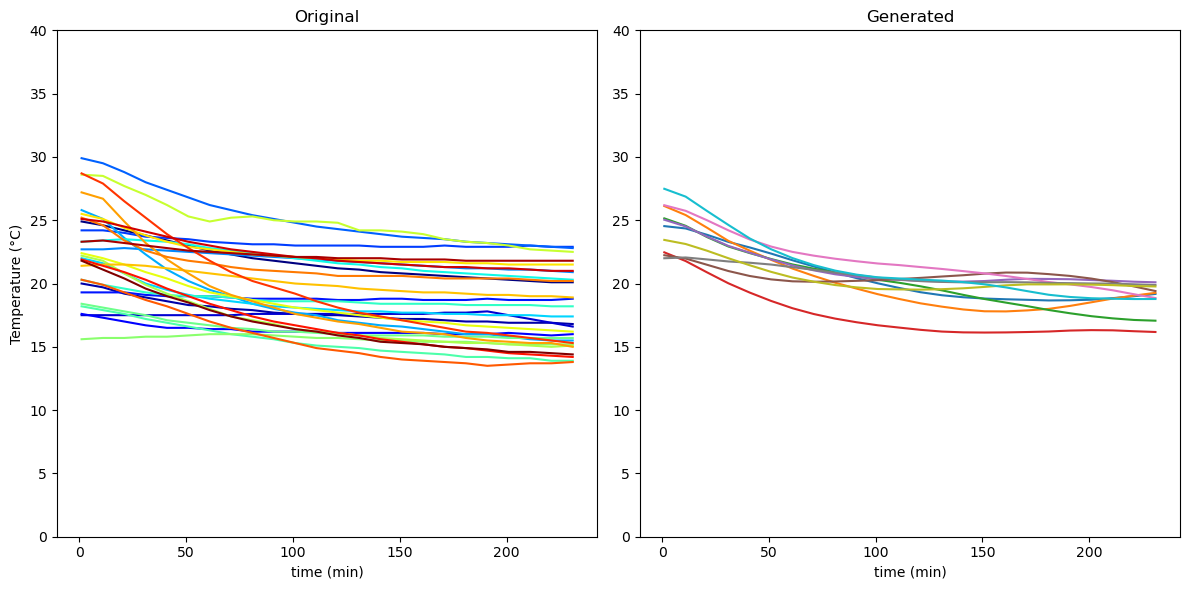

Training Progress:  60%|█████▉    | 599/1000 [00:54<00:35, 11.40it/s]

Epoch 600:
  Training - Loss = 0.1818, KL = -0.5882, MSE = 0.1759, CE = 0.1164
  Validation - Loss = 0.1066, KL = 0.1536, MSE = 0.1081, CE = 0.0485
  Mean q_mu = 2.7961, Mean q_var = 0.0498


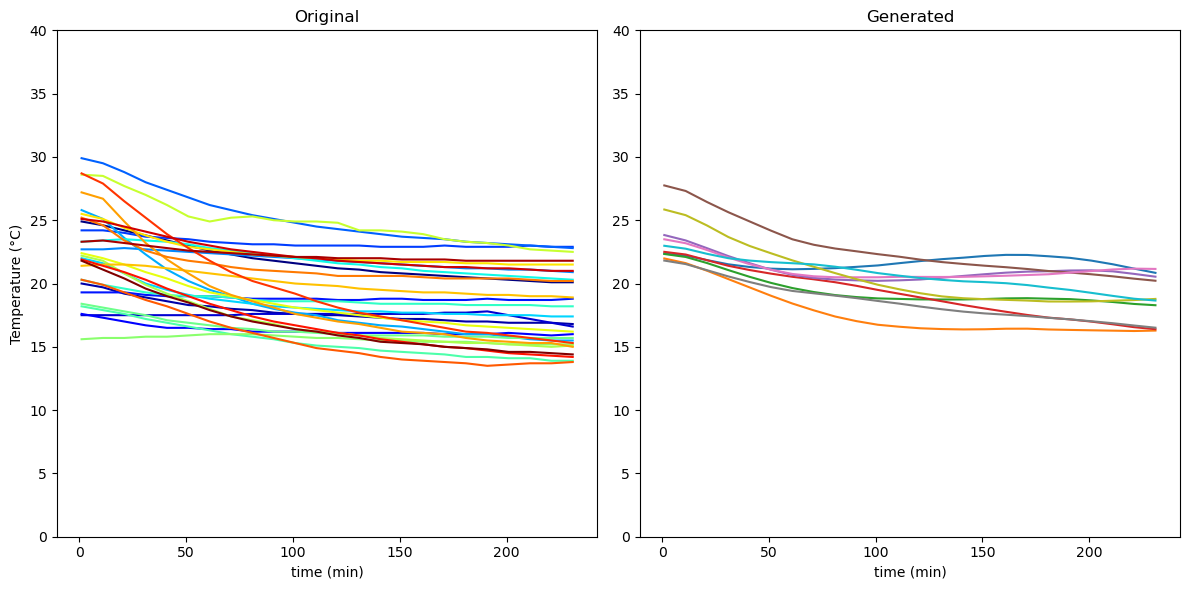

Training Progress:  65%|██████▍   | 649/1000 [00:59<00:31, 11.02it/s]

Epoch 650:
  Training - Loss = 0.1705, KL = -0.6769, MSE = 0.1637, CE = 0.1216
  Validation - Loss = 0.0978, KL = 0.1371, MSE = 0.0992, CE = 0.0527
  Mean q_mu = 3.0159, Mean q_var = 0.0498


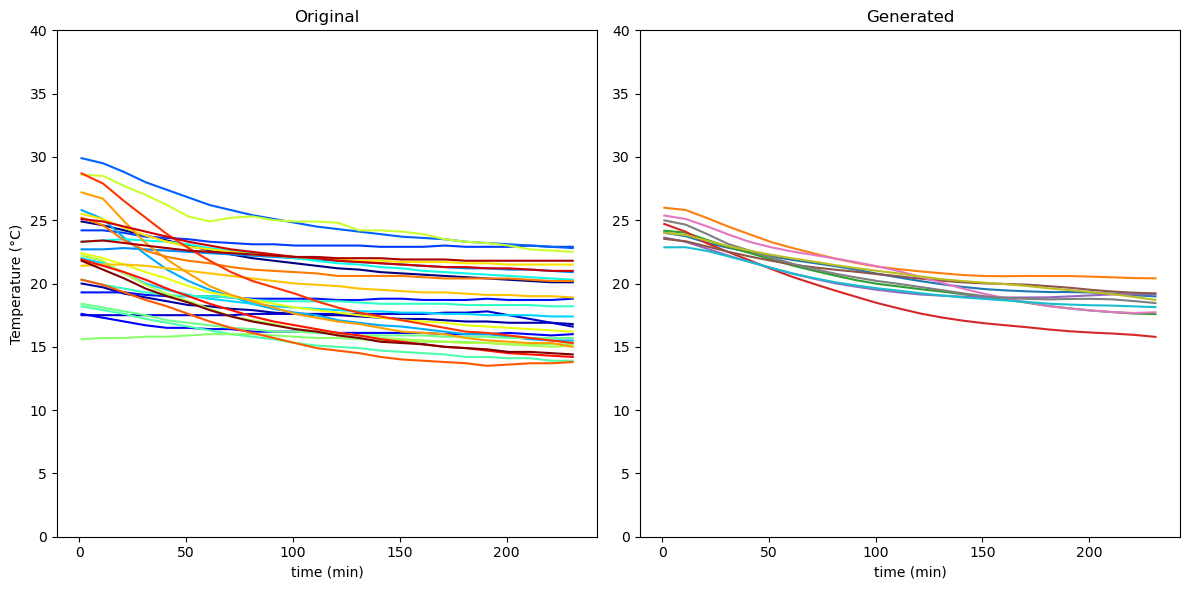

Training Progress:  70%|██████▉   | 699/1000 [01:04<00:26, 11.45it/s]

Epoch 700:
  Training - Loss = 0.1557, KL = -0.7364, MSE = 0.1483, CE = 0.1244
  Validation - Loss = 0.0829, KL = 0.1229, MSE = 0.0841, CE = 0.0563
  Mean q_mu = 3.1646, Mean q_var = 0.0498


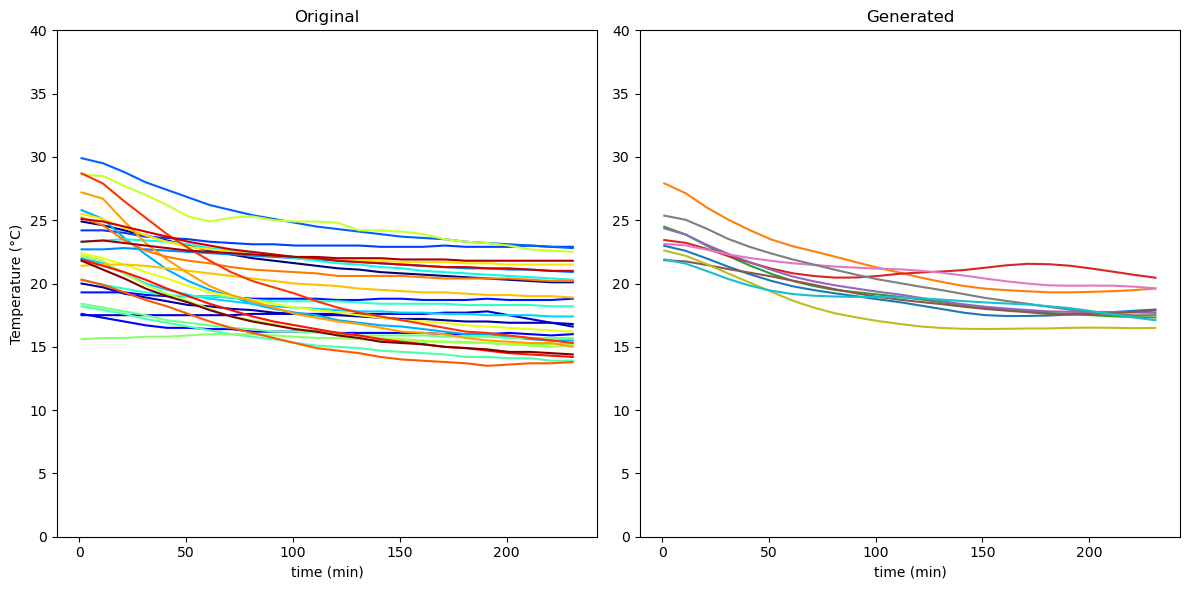

Training Progress:  75%|███████▍  | 749/1000 [01:08<00:21, 11.50it/s]

Epoch 750:
  Training - Loss = 0.1384, KL = -0.7753, MSE = 0.1307, CE = 0.1276
  Validation - Loss = 0.0844, KL = 0.1149, MSE = 0.0856, CE = 0.0591
  Mean q_mu = 3.2192, Mean q_var = 0.0498


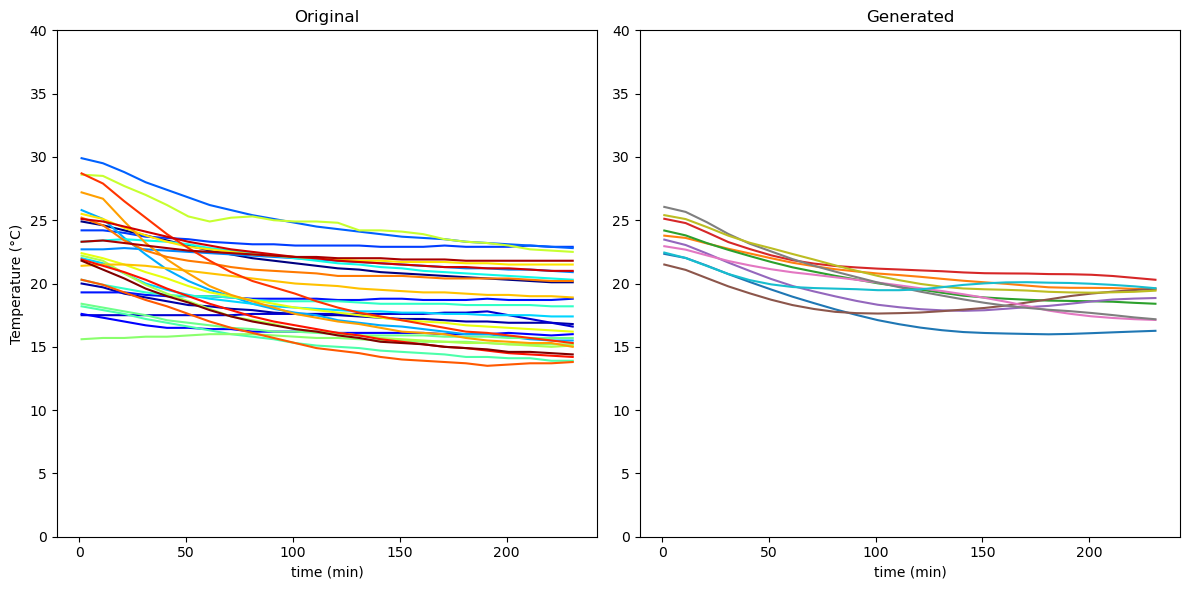

Training Progress:  80%|███████▉  | 799/1000 [01:13<00:17, 11.45it/s]

Epoch 800:
  Training - Loss = 0.1462, KL = -0.8387, MSE = 0.1378, CE = 0.1293
  Validation - Loss = 0.0843, KL = 0.1035, MSE = 0.0853, CE = 0.0621
  Mean q_mu = 3.3981, Mean q_var = 0.0498


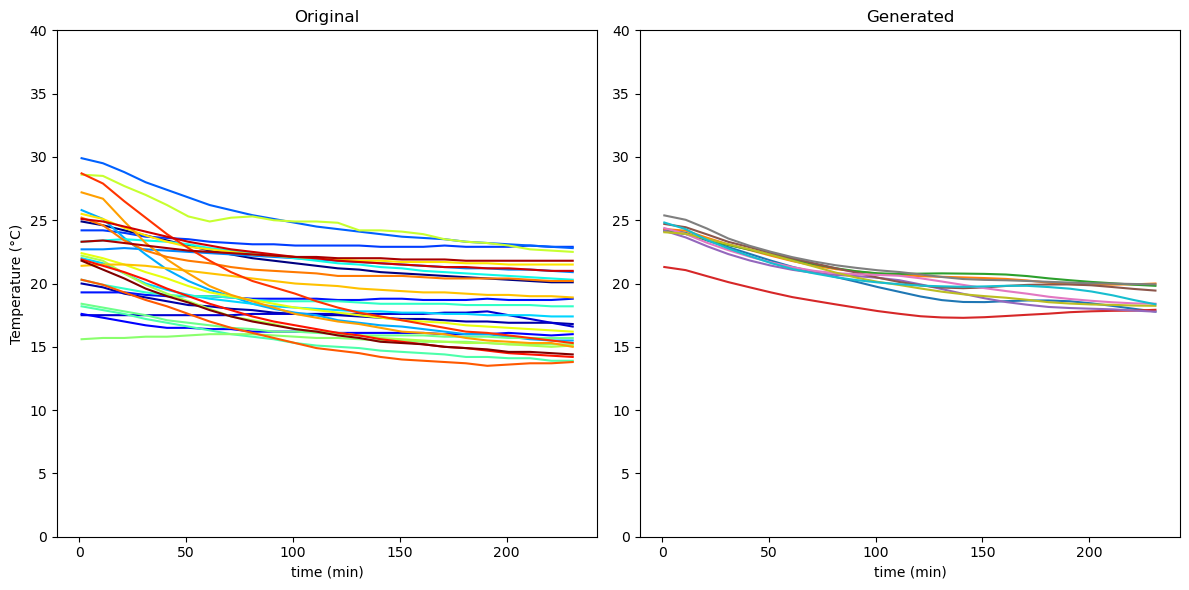

Training Progress:  85%|████████▍ | 849/1000 [01:17<00:13, 11.31it/s]

Epoch 850:
  Training - Loss = 0.1154, KL = -0.8818, MSE = 0.1066, CE = 0.1307
  Validation - Loss = 0.0709, KL = 0.0928, MSE = 0.0718, CE = 0.0649
  Mean q_mu = 3.5226, Mean q_var = 0.0498


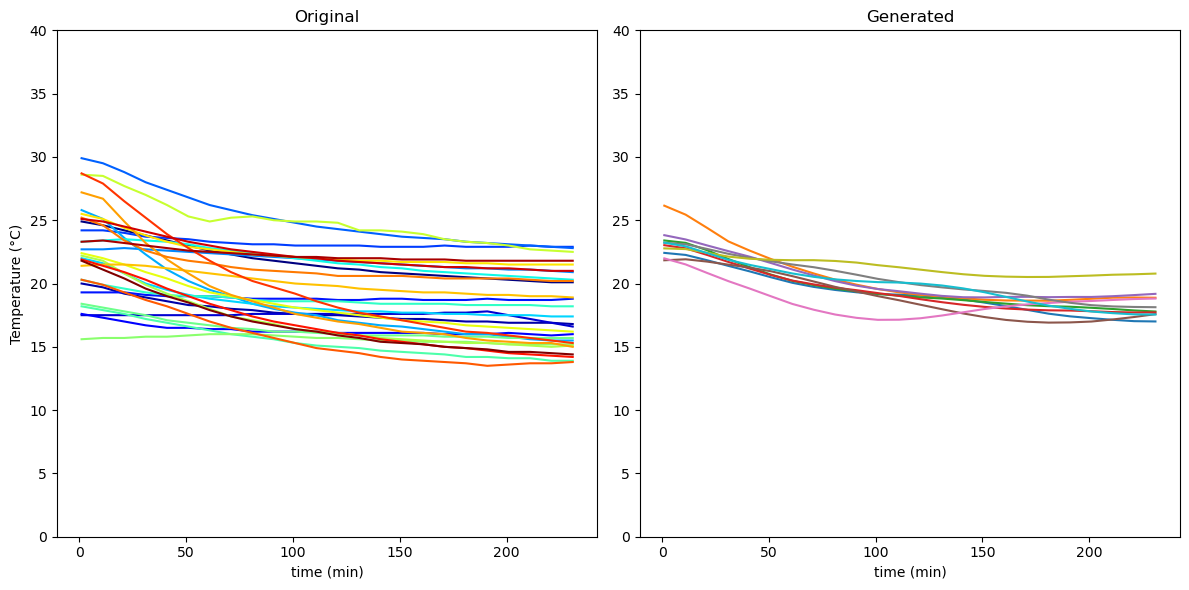

Training Progress:  90%|████████▉ | 899/1000 [01:22<00:08, 11.36it/s]

Epoch 900:
  Training - Loss = 0.1306, KL = -0.9321, MSE = 0.1213, CE = 0.1326
  Validation - Loss = 0.0558, KL = 0.0760, MSE = 0.0566, CE = 0.0685
  Mean q_mu = 3.6630, Mean q_var = 0.0498


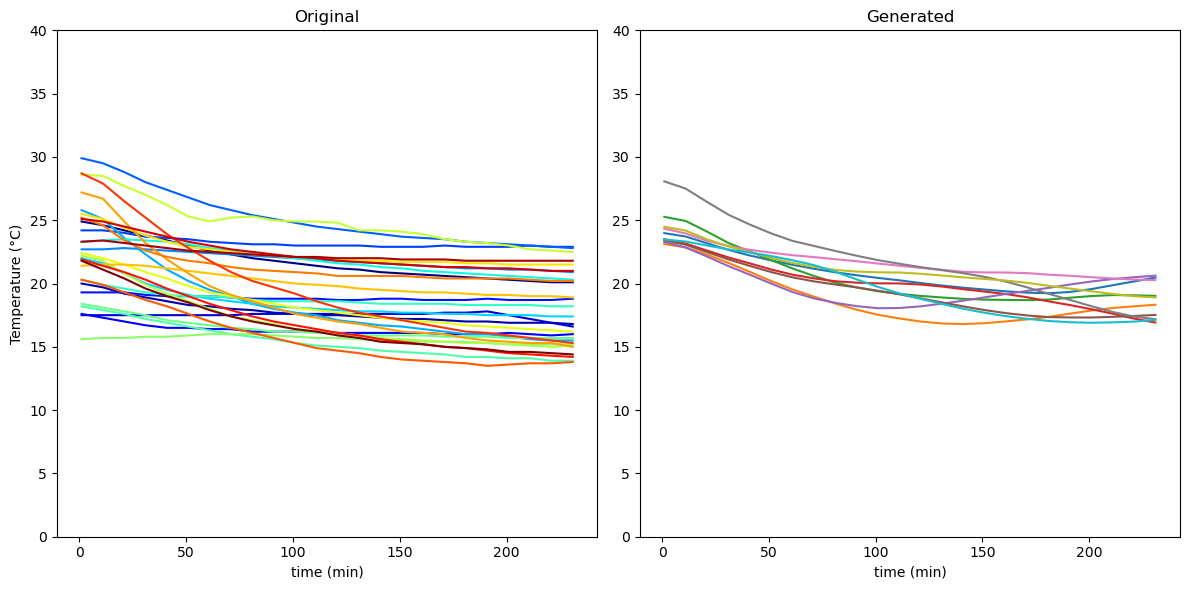

Training Progress:  95%|█████████▍| 949/1000 [01:27<00:04, 11.28it/s]

Epoch 950:
  Training - Loss = 0.1282, KL = -1.0024, MSE = 0.1182, CE = 0.1341
  Validation - Loss = 0.0846, KL = 0.0530, MSE = 0.0851, CE = 0.0727
  Mean q_mu = 3.8946, Mean q_var = 0.0498


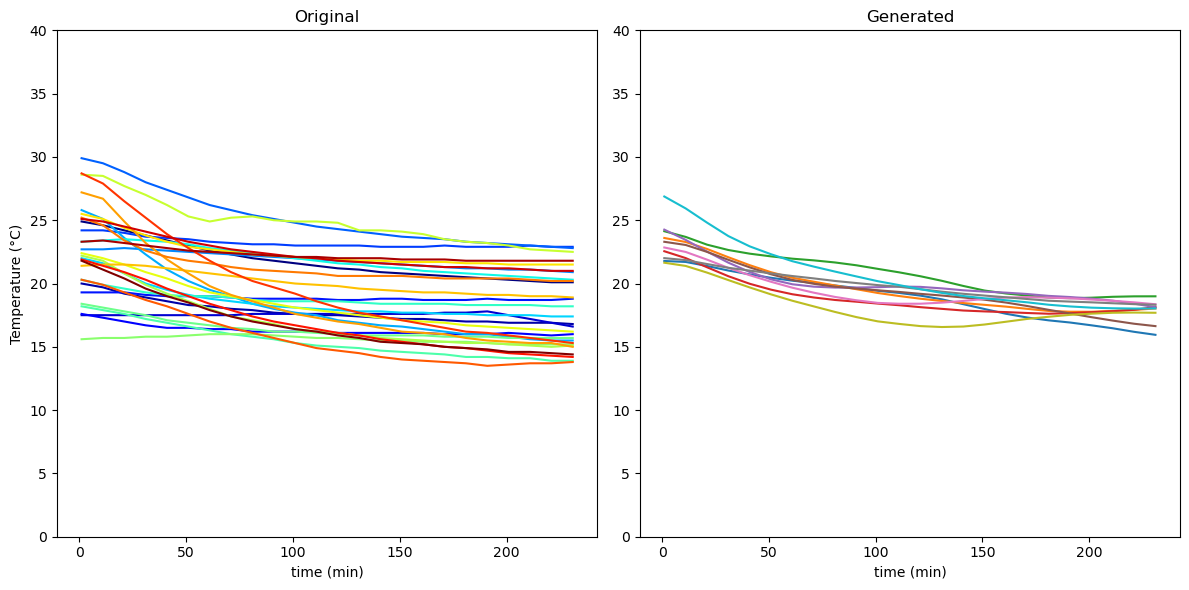

Training Progress: 100%|█████████▉| 998/1000 [01:31<00:00, 11.17it/s]

Epoch 1000:
  Training - Loss = 0.1165, KL = -1.0447, MSE = 0.1061, CE = 0.1351
  Validation - Loss = 0.0527, KL = 0.0505, MSE = 0.0532, CE = 0.0746
  Mean q_mu = 4.0433, Mean q_var = 0.0498


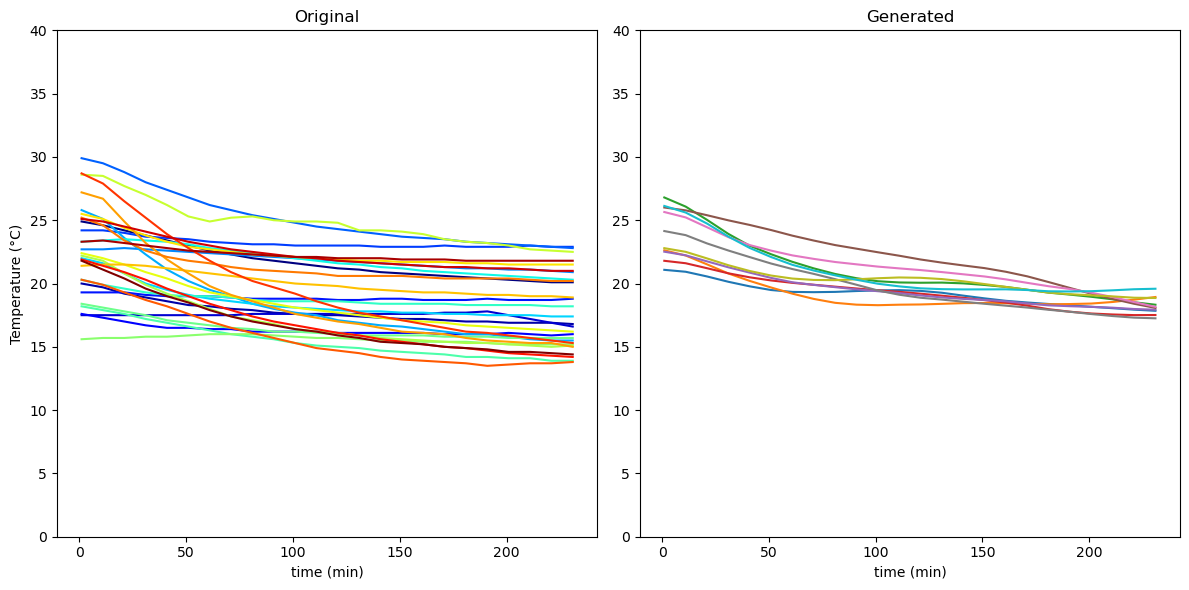

Training Progress: 100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


In [6]:
beta = 0.01
num_epochs = 1000
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni/240, 
                    num_samples=10, 
                    ylim=(0,40), 
                    df=df_c, 
                    plot=True)

In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/GPVAE_cooling.pth')